# Detection of Spatial Signatures in Houston

This notebook contains complete code required for a detection of spatial signatures in Houston, limited by its functional urban area.

This notebook relies on the `gds_env` as its main computational engine, which is deployed on a variety of servers and setups. This means that all the code produced in the project is reproducible under the containers provided in `gds_env`. This notebook uses `gds_py` flavour in a version `6.0`.

For more information on how to run `gds_env`, please visit:

> https://darribas.org/gds_env/

## Contents

- 1. Analysis of form
    - 1.1. Data retrieval
        - 1.1.1. Bulding footprints
        - 1.1.2. Street network
        - 1.1.3. Spatial barriers
    - 1.2. Data pre-processing
        - 1.2.1. Footprints checks and cleaning
        - 1.2.2. Barries checks and cleaning
    - 1.3. Generation of geographies
        - 1.3.1. Enclosures
        - 1.3.2. Enlclosed tessellation
    - 1.4. Morphometric analysis
        - 1.4.1. Primary morphometric characters
        - 1.4.2. Contextualisation
- 2. Analysis of function
    - 2.1. Population
    - 2.2. Land cover
    - 2.3. Night lights
    - 2.4. Workplace characteristics
    - 2.5. NDVI
    - 2.6. Historical sites
- 3. Cluster analysis
    - 3.1. Form
    - 3.2. Function
    - 3.3. Spatial Signatures
- 4. Figures

All packages and custom modules are imported below.

In [1]:
import glob
import pickle
import warnings
from time import time

import dask.dataframe as dd
import dask_geopandas
import fiona
import geopandas as gpd
import libpysal
import momepy
import networkx as nx
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
import pygeos
import pyrosm
import rasterstats
import rioxarray
import scipy
import utils
import utils.consolidate
import utils.momepy
import xarray
from clustergram import Clustergram
from dask.distributed import Client, LocalCluster, as_completed
from download import download
from rioxarray.merge import merge_arrays
from shapely.geometry import box, mapping
from sklearn import preprocessing
from sklearn.cluster import KMeans
from tqdm import tqdm
from utils.momepy_utils import (_circle_radius, centroid_corner, elongation,
                                get_corners, get_edge_ratios, get_nodes,
                                solar_orientation_poly, squareness)

Most of our data will be stored as geospatial parquet files, which is currently (Feb 2021) in its intial implementation, but we know that and can filter warnings.

In [2]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

First we specify a path to a folder for a data storage.

In [4]:
folder = folder + "../../urbangrammar_samba/sp_sig_concept/houston/"

Case study area is limited by functional urban area (FUA), so let's open all FUAs and filter our polygon.

In [ ]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

polygon = fua_4326[fua_4326.eFUA_name == 'Houston'].geometry.iloc[0]

## 1. Analysis of form

First step towards spatial signtures is an analysis of urban form to capture its patterns.

### 1.1. Data retrieval

All data used in the work are obtained from open access sources.

#### 1.1.1 Building footprints

For Houston, we will use [Microsoft building footprints](https://www.microsoft.com/en-us/maps/building-footprints), which means we have to download Texas and extract Houston FUA.

In [4]:
download("https://usbuildingdata.blob.core.windows.net/usbuildings-v1-1/Texas.zip", folder + 'texas_footprint', kind='zip')

Creating data folder...

file_sizes: 100%|████████████████████████████| 341M/341M [00:54<00:00, 6.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint


'../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint'

We read only those within our polygon.

In [8]:
buildings = gpd.read_file(folder + "texas_footprint/Texas.geojson", mask=polygon)

We check geometry validity and fix it.

In [10]:
buildings.is_valid.all()

False

In [11]:
buildings.geometry = buildings.buffer(0)

In [12]:
buildings.is_valid.all()

True

Finally, we assign unique ID to each row.

In [13]:
buildings['uID'] = range(len(buildings))

In [14]:
buildings.to_parquet(folder + "buildings.pq")

#### 1.1.2 Street network

Street network is obtined from OSM using OSMnx, and custom tags.

We get a graph, project it, turn into undirected one and export to GeoDataFrame. Then we make sure `highway` parameter is string and can be saved to file.

In [15]:
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = folder + 'roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

#### 1.1.3. Spatial barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore, we download railway and water geometry from OSM.

##### Water

In [ ]:
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(polygon, tags)
path = folder + 'water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

##### Railway

Then we get railway and filter out proper geometry type (we want LineStrings representing railway tracks) and remove tunnels (those are not spatial barriers)..

In [ ]:
tags = {'railway': True}
gdf = ox.geometries_from_polygon(polygon, tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = folder + 'railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

### 1.2. Data pre-processing

Before we can analyse form using the data we just downloaded, we need to ensure that they are in a proper form.

#### 1.2.1. Footprints checks and cleaning

Let's start with building footprints.

In [18]:
buildings.geom_type.value_counts()

Polygon         1874421
MultiPolygon          9
dtype: int64

We explode geometries and keep only polygons.

In [19]:
buildings = buildings.explode().reset_index(drop=True)

We reproject geometries to our selected CRS.

In [20]:
buildings = buildings.to_crs(3081)

In [21]:
buildings.is_valid.all()

True

Since we have exploded some MultiPolygons, let's create fresh ID.

In [23]:
buildings['uID'] = range(len(buildings))

In [ ]:
buildings.to_parquet(folder + "buildings.pq")

#### 1.2.2. Barries checks and cleaning

Let's now check our barriers and close potential unwanted gaps to generate clean enclosures

In [ ]:
railway = gpd.read_parquet(folder + 'railway_osm.pq').to_crs(buildings.crs)

In [26]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [27]:
roads = gpd.read_parquet(folder + 'roads_osm.pq').to_crs(buildings.crs)

Roads seems to be fine, similarly to railway. The only step we do is extension of railway lines to snap to roads.

In [34]:
%time extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

CPU times: user 3.07 s, sys: 16 ms, total: 3.09 s
Wall time: 3.08 s


In [35]:
water = gpd.read_parquet(folder + "water_osm.pq").to_crs(buildings.crs)

In [36]:
water.geom_type.value_counts()

Polygon         5210
LineString       242
MultiPolygon       9
Point              2
dtype: int64

We do not want point water features and for polygons, we want their boudaries.

In [37]:
water = water[~(water.geom_type == "Point")].explode()
water.loc[water.geom_type == "Polygon", "geometry"] = water.loc[water.geom_type == "Polygon", "geometry"].boundary

### 1.3. Generation of geographies

Now we have to create geographies we will be using in the analysis. Enclosures and enclosed tessellation.

#### 1.3.1. Enclosures

Enclosures require spatial barriers, which are roads, water and railway (we use the extended one we did above), limited by FUA.

In [42]:
limit = fua_4326[fua_4326.eFUA_name == 'Houston'].to_crs(buildings.crs).geometry.iloc[[0]]

In [43]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=limit, additional_barriers=[extended_railway, water])

CPU times: user 2min 30s, sys: 68 ms, total: 2min 30s
Wall time: 2min 30s


In [ ]:
enclosures.to_parquet(folder + "enclosures.pq")

#### 1.3.2. Enclosed tessellation

With enclosures and buildings, we can now create enclosed tessellation. To have a better control of dask cluster, we can create it directly (enclosed tessellation is a dask-parallelised function).

In [3]:
enclosures = gpd.read_parquet(folder + "enclosures.pq")
buildings = gpd.read_parquet(folder + "buildings.pq")

In [3]:
client = Client(LocalCluster(n_workers=16))
client

<Client: 'tcp://127.0.0.1:40391' processes=16 threads=16, memory=134.91 GB>

In [5]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures, n_chunks=16)

/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 338.34 MB detected in task graph: 
  ([           eID                                   ...  0.05, 'uID'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 11min 56s, sys: 1min 9s, total: 13min 6s
Wall time: 2h 5min 27s


Now we can assign unique ID to each tessellation cell and save them. 

In [ ]:
tessellation = tess.tessellation
tessellation['tID'] = range(len(tessellation))
tessellation.to_parquet(folder + "tessellation.pq")

### 1.4. Morphometric analysis

Morpohmetric analysis first measures primary characters, which are then contextualised to capture the tendencies within the local context of each tessellation cell.

#### 1.4.1. Primary morphometric characters

For the analysis we need four input layer representing urban form - buildings, streets, enclosed tessellation and enclosures.

In [4]:
tess = gpd.read_parquet(folder + "tessellation.pq")
enclosures = gpd.read_parquet(folder + "enclosures.pq")
buildings = gpd.read_parquet(folder + "buildings.pq")

In many cases, we will need to relate buildings to tessellation cells. the best way to ensure the proper linkage is to combine both GeoDataFrames into a single one with two named geometry columns. Then we can assign unique ID to each tessellation cell. Remember that not every cell has assigned a building.

In [5]:
tess = tess.rename_geometry("tessellation").merge(
    blg[["uID", "geometry"]].rename_geometry("buildings"), on="uID", how="left"
)

In [6]:
tess.head(5)

uID                                       tessellation  eID  tID  \
0  114604.0  POLYGON ((1444405.065 789808.767, 1444407.122 ...    0    0   
1  601963.0  POLYGON ((1444529.267 789801.698, 1444529.292 ...    0    1   
2  656147.0  POLYGON ((1444435.839 789772.425, 1444435.372 ...    0    2   
3  692179.0  POLYGON ((1444416.947 789806.634, 1444416.627 ...    0    3   
4  782446.0  POLYGON ((1444480.706 789774.447, 1444480.824 ...    0    4   

                                           buildings  
0  POLYGON ((1444429.613 789804.887, 1444430.130 ...  
1  POLYGON ((1444526.829 789799.830, 1444514.312 ...  
2  POLYGON ((1444456.635 789818.966, 1444457.869 ...  
3  POLYGON ((1444416.132 789808.871, 1444415.876 ...  
4  POLYGON ((1444485.052 789794.666, 1444484.310 ...

In [7]:
tess.shape

(2043581, 5)

The GeoDataFrame is large (2 millions tessellation cells), therefore we try to paralellise as much as we can. For that, we use dask-geopandas, which is an attempt to parallelize GeoPandas usign dask.dataframe and distributed computation with Dask. As of February '21, dask-geopandas is still in alpha version but as you will see, we can already do a lot.

To have a better control over local dask cluster, we can create one manually (note that the machine we use has 16 cores).

We create dask.GeoDataFrame from our geodataframe with number of partitions equal to number of workers in a cluster.

In [8]:
ddf = dask_gpd.from_geopandas(tess, npartitions=16)

You may see in other notebooks in this project, that the following section is using `momepy` to measure morphometric characters. The following cell contains the same functions, just written for dask (momepy works with pure GeoPandas). Refer to the [documentation of momepy](https://docs.momepy.org) for details on each one of them. Each result is assigned as a new column.

In [ ]:
%%time
## Measure morphometric characters
# Building area
ddf['sdbAre'] = ddf.buildings.area

# Building perimeter
ddf['sdbPer'] = ddf.buildings.length

# Courtyard area
exterior_area = ddf.buildings.map_partitions(lambda series: pygeos.area(pygeos.polygons(series.exterior.values.data)), meta='float')
ddf['sdbCoA'] = exterior_area - ddf['sdbAre']

# Circular compactness
hull = ddf.buildings.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
ddf['ssbCCo'] = ddf['sdbAre'] / (np.pi * radius ** 2)

# Corners
ddf['ssbCor'] = ddf.buildings.apply(lambda g: get_corners(g), meta='float')

# Squareness
ddf['ssbSqu'] = ddf.buildings.apply(lambda g: squareness(g), meta='float')

# Equivalent rectangular index
bbox = ddf.buildings.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=gpd.GeoSeries())
ddf['ssbERI'] = (ddf['sdbAre'] / bbox.area).pow(1./2) * (bbox.length / ddf['sdbPer'])

# Elongation
ddf['ssbElo'] = bbox.map_partitions(lambda s: elongation(s), meta='float')

# Centroid corner mean distance and deviation
def _centroid_corner(series):
    ccd = series.apply(lambda g: centroid_corner(g))
    return pd.DataFrame(ccd.to_list(), index=series.index)


ddf[['ssbCCM', 'ssbCCD']] = ddf.buildings.map_partitions(_centroid_corner, meta=pd.DataFrame({0: [0.1], 1: [1.1]}))

# Solar orientation
ddf['stbOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Tessellation longest axis length
hull = ddf.tessellation.convex_hull.exterior

ddf['sdcLAL'] = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2

# Tessellation area
ddf['sdcAre'] = ddf.tessellation.area

# Circular compactness
radius = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float')
ddf['sscCCo'] = ddf['sdcAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = ddf.tessellation.apply(lambda g: g.minimum_rotated_rectangle, meta=gpd.GeoSeries())
ddf['sscERI'] = (ddf['sdcAre'] / bbox.area).pow(1./2) * (bbox.length / ddf.tessellation.length)

# Solar orientation
ddf['stcOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Covered area ratio
ddf['sicCAR'] = ddf['sdbAre'] / ddf['sdcAre']

# Building-cell alignment
ddf['stbCeA'] = (ddf['stbOri'] - ddf['stcOri']).abs()

# Compute all characters using dask
df = ddf.compute()

We can save our intermediate result to a parquet.

In [10]:
df.to_parquet(folder + "tess.pq")

Now we use the same approach to measure characters on enclosures.

In [11]:
%%time
# Load data
encl = dask_gpd.from_geopandas(enclosures, npartitions=16)

# Area
encl['ldeAre'] = encl.geometry.area

# Perimeter
encl['ldePer'] = encl.geometry.length

# Circular compacntess
hull = encl.geometry.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
encl['lseCCo'] = encl['ldeAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = encl.geometry.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=gpd.GeoSeries())
encl['lseERI'] = (encl['ldeAre'] / bbox.area).pow(1./2) * (bbox.length / encl['ldePer'])

# Compactness-weighted axis
longest_axis = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2
encl['lseCWA'] = longest_axis * ((4 / np.pi) - (16 * encl['ldeAre']) / ((encl['ldePer']) ** 2))

# Solar orientation
encl['lteOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Compute data and return gpd.GeoDataFrame
encl_df = encl.compute()

# Weighted number of neighbors
inp, res = encl_df.sindex.query_bulk(encl_df.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
encl_df['neighbors'] = counts - 1
encl_df['lteWNB'] = encl_df['neighbors'] / encl_df['ldePer']

# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = encl_df[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
encl_df['lieWCe'] = merged['tessellation'] / merged['ldeAre']

CPU times: user 40.2 s, sys: 1.02 s, total: 41.2 s
Wall time: 52.3 s


In [12]:
# Save data to parquet
encl_df.to_parquet(folder + "enclosures.pq")

#### Chunk the data

Some functions are hard to parallelize. Therefore we split the data into chunks and run the analysis on those.

In [3]:
cells = gpd.read_parquet(folder + "tess.pq")

In [6]:
bounds = cells.total_bounds

First, we create a grid over the extent.

In [53]:
size = 7
grid = gpd.points_from_xy(
    np.repeat(np.linspace(bounds[0], bounds[2], size), size), np.tile(np.linspace(bounds[1], bounds[3], size), size)
)

In [54]:
grid, _ = libpysal.cg.voronoi_frames(np.stack([np.repeat(np.linspace(bounds[0], bounds[2], size), size), np.tile(np.linspace(bounds[1], bounds[3], size), size)]).T, clip="bbox")

<AxesSubplot:>

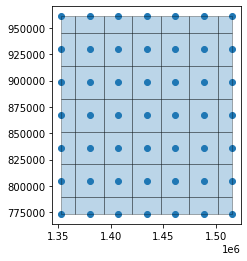

In [55]:
ax = _.plot()
grid.plot(ax=ax, edgecolor="k", alpha=.3)

We assing ID to each grid cell and spatially join them to tessellation.

In [56]:
grid['chunkid'] = range(len(grid))

In [ ]:
%time join = gpd.sjoin(gpd.GeoDataFrame(geometry=cells.tessellation.centroid), grid, how='left')

We save grid for later.

In [59]:
grid.to_parquet(folder + "chunks.pq")

We save chunked data to separate files.

In [60]:
for i in join.chunkid.unique():
    cells[join["chunkid"] == i].to_parquet(folder + f"chunked/chunk_{i}.pq")

We also need to know the neighbors of each chunk, to avoid boundary effect. We first create spatial weights.

In [67]:
w = libpysal.weights.fuzzy_contiguity(grid)

In [68]:
grid = grid.set_index("chunkid")

How many chunks we actaully have?

In [63]:
total = len(glob.glob(folder + "chunked/*"))
total

31

Now we loop over each chunk, get neighbouring chunks and IDs of close-by tessellation cells from each of the neighbouring chunks.

In [72]:
include = pd.Series(index=pd.MultiIndex.from_tuples([], names=['chunk', 'neighbors']), dtype=object)

for ch in tqdm(join.chunkid.unique(), total=total):
    target = grid.loc[ch, 'geometry']

    for n in w.neighbors[ch]:
        try:
            tess = gpd.read_parquet(folder + f"chunked/chunk_{int(n)}.pq")

            ind = tess.sindex.query(target, predicate='intersects')

            if ind.size > 0:
                incl = ind.tolist()
                for _ in range(12):
                    inp, res = tess.sindex.query_bulk(tess.geometry.iloc[incl], predicate='intersects')
                    incl += np.unique(res).tolist()
            else:
                incl = []
            include.loc[ch, int(n)] = np.unique(incl)
        except:
            pass

100%|██████████| 31/31 [29:59<00:00, 58.05s/it] 


And we filter out empty lists.

In [73]:
include = include[include.apply(lambda x: len(x) > 0)]

In [74]:
include

chunk  neighbors
22     21           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
       29           [445, 448, 451, 452, 463, 472, 485, 502, 507, ...
       15           [3, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 43...
       30           [409, 418, 471, 476, 478, 481, 483, 491, 496, ...
       23           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                                          ...                        
2      9            [1404, 1408, 1413, 1631, 1632, 1633, 1634, 163...
28     21           [225, 273, 274, 275, 276, 277, 279, 282, 283, ...
       22           [1428, 1429, 1430, 1431, 1432, 1433, 1434, 143...
       29           [3189, 3190, 3191, 3192, 3193, 3194, 3196, 319...
1      8            [1633, 1634, 1635, 1636, 1637, 1638, 1639, 164...
Length: 110, dtype: object

Now we know that, for example, chunk 22 has 21 as a neighbour and we should load its cells with ID [0, 1, ... 13 ...] while measuring stuff on chunk 22. Let's save this information.

In [75]:
pd.DataFrame(include, columns=['indices']).to_parquet(folder + 'cross-chunk_indices.pq')

#### Generate spatial weights (W)

Subsequent steps will require understanding of the context of each tessellation cell in a form of spatial weights matrices (Queen contiguity and Queen contiguty of inclusive 3rd order). We generate them beforehand and store as npz files representing sparse matrix.

Each geo-chunk is loaded together with relevant cross-chunk tessellation cells (to avoid edge effect). We use dask to parallelise the iteration. Number of workers is smaller now to ensure enough memory for each chunk.

In [2]:
workers = 16
client = Client(LocalCluster(n_workers=8, threads_per_worker=2))
client

<Client: 'tcp://127.0.0.1:34487' processes=8 threads=16, memory=134.91 GB>

In [4]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*Assigning CRS to a GeoDataFrame without a geometry*')

In [5]:
cross_chunk = pd.read_parquet(folder + 'cross-chunk_indices.pq')
chunks = gpd.read_parquet(folder + "chunks.pq")

First we have to specify a function doing the processing itself, where the only attribure is the chunk_id.

In [5]:
def generate_w(chunk_id):
    # load cells of a chunk
    try:
        cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk_id}.pq")

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk}.pq").iloc[inds]
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)

        w = libpysal.weights.Queen.from_dataframe(df, geom_col='tessellation')
        w3 = momepy.sw_high(k=3, weights=w)

        scipy.sparse.save_npz(folder + f"weights/w_{chunk_id}.npz", w.sparse)
        scipy.sparse.save_npz(folder + f"weights/w3_{chunk_id}.npz", w3.sparse)

        return f"Chunk {chunk_id} processed sucessfully."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

Then we use dask to iterate over all chunks. The following script sends first 8 chunks to dask together and then submits a new chunk as soon as any of previous finishes. That way we process only 8 chunks at once ensuring that we the cluster will not run out of memory.

In [ ]:
%%time
inputs = iter(range(49))
futures = [client.submit(generate_w, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Not all IDs in the range are actually used as chunks. Let's find out actual chunks.

In [3]:
real_chunks = [int(i[-5:-3].replace("_", "")) for i in glob.glob(folder + "chunked/*")]

Some of them failed due to memory demands. Which?

In [7]:
done = [int(i[-6:-4].replace("_", "")) for i in glob.glob(folder + "weights/w3_*")]
missing = [i for i in real_chunks if i not in done]

In [8]:
missing

[24, 30, 23]

We can make a new cluster with less workers to give each more memory.

In [9]:
workers = 3
client = Client(LocalCluster(n_workers=3, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:43007' processes=3 threads=3, memory=134.91 GB>

In [10]:
inputs = missing
futures = [client.submit(generate_w, next(inputs)) for i in range(3)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 30 processed sucessfully.
Chunk 23 processed sucessfully.
Chunk 24 processed sucessfully.


#### Spatial distribution and network analysis

To measure spatial distribution of we use single-core algorithm and parallelise iteration as we did before.

In [5]:
workers = 16
client = Client(LocalCluster(n_workers=16, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:42987' processes=16 threads=16, memory=134.91 GB>

Within the same function below we measure spatial distribution of elements and network-based characters.

In [41]:
def measure(chunk_id):
    try:
        # load cells of a chunk
        cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk_id}.pq")
        cells['keep'] = True

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk}.pq").iloc[inds]
            add_cells['keep'] = False
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)

        # read W
        w = libpysal.weights.WSP(scipy.sparse.load_npz(folder + f"weights/w_{chunk_id}.npz")).to_W()

        # alignment
        def alignment(x, orientation='stbOri'):
            orientations = df[orientation].iloc[w.neighbors[x]]
            return abs(orientations - df[orientation].iloc[x]).mean()

        df['mtbAli'] = [alignment(x) for x in range(len(df))]

        # mean neighbour distance
        def neighbor_distance(x):
            geom = df.buildings.iloc[x]
            if geom is None:
                return np.nan
            return df.buildings.iloc[w.neighbors[x]].distance(df.buildings.iloc[x]).mean()

        df['mtbNDi'] = [neighbor_distance(x) for x in range(len(df))]

        # weighted neighbours
        df['mtcWNe'] = pd.Series([w.cardinalities[x] for x in range(len(df))], index=df.index) / df.tessellation.length

        # area covered by neighbours
        def area_covered(x, area='sdcAre'):
            neighbours = [x]
            neighbours += w.neighbors[x]

            return df[area].iloc[neighbours].sum()

        df['mdcAre'] = [area_covered(x) for x in range(len(df))]

        # read W3
        w3 = libpysal.weights.WSP(scipy.sparse.load_npz(folder + f"weights/w3_{chunk_id}.npz")).to_W()

        # weighted reached enclosures
        def weighted_reached_enclosures(x, area='sdcAre', enclosure_id='eID'):
            neighbours = [x]
            neighbours += w3.neighbors[x]

            vicinity = df[[area, enclosure_id]].iloc[neighbours]

            return vicinity[enclosure_id].unique().shape[0] / vicinity[area].sum()

        df['ltcWRE'] = [weighted_reached_enclosures(x) for x in range(len(df))]

        # mean interbuilding distance
        # define adjacency list from lipysal
        adj_list = w.to_adjlist(remove_symmetric=False)
        adj_list["weight"] = (
            df.buildings.iloc[adj_list.focal]
            .reset_index(drop=True)
            .distance(df.buildings.iloc[adj_list.neighbor].reset_index(drop=True)).values
        )

        G = nx.from_pandas_edgelist(
                adj_list, source="focal", target="neighbor", edge_attr="weight"
            )
        ibd = []
        for i in range(len(df)):
            try:
                sub = nx.ego_graph(G, i, radius=3)
                ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))
            except:
                ibd.append(np.nan)

        df['ltbIBD'] = ibd

        # Reached neighbors and area on 3 topological steps on tessellation
        df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]
        df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

        # Save cells to parquet keeping only within-chunk data not the additional neighboring
        df[df['keep']].drop(columns=['keep']).to_parquet(folder + f"chunked/chunk_{chunk_id}.pq")

        # Load street network for an extended chunk area
        chunk_area = chunks.geometry.iloc[chunk_id].buffer(5000)  # we extend the area by 5km to minimise edge effect
        streets = gpd.read_parquet(folder + 'roads_osm.pq').to_crs(df.crs)
        streets = gpd.clip(streets, chunk_area).explode()

        # Street profile (measures width, width deviation and openness)
        sp = momepy.StreetProfile(streets, df.set_geometry("buildings"))
        streets['sdsSPW'] = sp.w
        streets['sdsSWD'] = sp.wd
        streets['sdsSPO'] = sp.o

        # Street segment length
        streets['sdsLen'] = streets.length

        # Street segment linearity
        streets['sssLin'] = momepy.Linearity(streets).series

        # Convert geopadnas.GeoDataFrame to networkx.Graph for network analysis
        G = momepy.gdf_to_nx(streets)

        # Node degree
        G = momepy.node_degree(G)

        # Subgraph analysis (meshedness, proportion of 0, 3 and 4 way intersections, local closeness)
        G = momepy.subgraph(
            G,
            radius=5,
            meshedness=True,
            cds_length=False,
            mode="sum",
            degree="degree",
            length="mm_len",
            mean_node_degree=False,
            proportion={0: True, 3: True, 4: True},
            cyclomatic=False,
            edge_node_ratio=False,
            gamma=False,
            local_closeness=True,
            closeness_weight="mm_len",
            verbose=False
        )

        # Cul-de-sac length
        G = momepy.cds_length(G, radius=3, name="ldsCDL", verbose=False)

        # Square clustering
        G = momepy.clustering(G, name="xcnSCl")

        # Mean node distance
        G = momepy.mean_node_dist(G, name="mtdMDi", verbose=False)

        # Convert networkx.Graph back to GeoDataFrames and W (denoting relationships between nodes)
        nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

        # Generate inclusive higher order weights
        edges_w3 = momepy.sw_high(k=3, gdf=edges)

        # Mean segment length
        edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

        # Generate inclusive higher order weights
        nodes_w5 = momepy.sw_high(k=5, weights=sw)

        # Node density
        nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5, verbose=False).series

        # Weighter node density
        nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False).series

        # Save to parquets
        edges.to_parquet(folder + f"edges/edges_{chunk_id}.pq")
        nodes.to_parquet(folder + f"nodes/nodes_{chunk_id}.pq")


        return f"Chunk {chunk_id} processed sucessfully."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

Again we use dask to iterate over all chunks. The following script sends first 8 chunks to dask together and then submits a new chunk as soon as any of previous finishes. That way we process only 8 chunks at once ensuring that we the cluster will not run out of memory for most of the chunks.

In [ ]:
inputs = iter(real_chunks)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Those which failed due to memory issues can then be run using larger workers as above.

In [47]:
done = [int(i[-5:-3].replace("_", "")) for i in glob.glob(folder + "nodes/nodes_*")]
missing = [i for i in real_chunks if i not in done]
missing

[24, 30, 23]

In [48]:
workers = 3
client = Client(LocalCluster(n_workers=3, threads_per_worker=1))
client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39309 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37621' processes=3 threads=3, memory=134.91 GB>

In [49]:
inputs = iter(missing)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 30 processed sucessfully.
Chunk 23 processed sucessfully.
Chunk 24 processed sucessfully.


In [52]:
client.close()

#### Link together

For the further analysis, we need to link data measured on individual elements together. We link cells to edges based on the proportion of overlap (if a cell intersects more than one edge) and nodes based on proximity (with a restriction - node has to be on linked edge). Enclosures are linked based on enclosure ID.

As above, we define a single-core function and use dask to manage parallel iteration.

In [6]:
def link(chunk_id):
    try:
        s = time()
        cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk_id}.pq")
        edges = gpd.read_parquet(folder + f"edges/edges_{chunk_id}.pq")
        nodes = gpd.read_parquet(folder + f"nodes/nodes_{chunk_id}.pq")

        cells['edgeID'] = get_edge_ratios(cells, edges)
        cells['nodeID'] = get_nodes(cells, nodes, edges, 'nodeID', 'edgeID', 'node_start', 'node_end')

        characters = ['sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL']
        l = []
        for d in cells.edgeID:
            l.append((edges.iloc[list(d.keys())][characters].multiply(list(d.values()), axis='rows')).sum(axis=0))
        cells[characters] = pd.DataFrame(l, index=cells.index)

        cells = cells.merge(nodes.drop(columns=['geometry']), on='nodeID', how='left')
        cells = cells.rename({'degree': 'mtdDeg', 'meshedness': 'lcdMes', 'proportion_3': 'linP3W', 'proportion_4': 'linP4W',
                         'proportion_0': 'linPDE', 'local_closeness': 'lcnClo'}, axis='columns')

        cells['edgeID_keys'] = cells.edgeID.apply(lambda d: list(d.keys()))
        cells['edgeID_values'] = cells.edgeID.apply(lambda d: list(d.values()))

        cells.drop(columns='edgeID').to_parquet(folder + f"chunked/chunk_{chunk_id}.pq")

        return f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [6]:
workers = 16
client = Client(LocalCluster(n_workers=16, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:39319' processes=16 threads=16, memory=134.91 GB>

In [ ]:
inputs = iter(real_chunks)
futures = [client.submit(link, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(link, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

In [14]:
client.close()

Enclosures are linked via simple attribute join and since the operation is does not require any computation, it is done as a simple loop.Now we just link data from enclosures to tessellation.

In [ ]:
enclosures = pd.read_parquet(folder + "enclosures.pq")
for chunk_id in real_chunks:
    s = time()
    cells = gpd.read_parquet(folder + f"chunked/chunk_{chunk_id}.pq")

    cells = cells.merge(enclosures.drop(columns=['neighbors']), on='eID', how='left')

    cells.to_parquet(folder + f"chunked/chunk_{chunk_id}.pq")

    print(f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds.")

#### Inter-element characters

The remaining morphometric characters are based on a relations between multiple elements. The implementation mirrors the approach above.

In [6]:
workers = 16
client = Client(LocalCluster(n_workers=8, threads_per_worker=2))
client

<Client: 'tcp://127.0.0.1:33391' processes=8 threads=16, memory=134.91 GB>

In [10]:
def measure(chunk_id):
    try:
        s = time()
        # Load data
        cells = gpd.read_parquet(folder + "chunked/chunk_{chunk_id}.pq")
        edges = gpd.read_parquet(folder + "edges/edges_{chunk_id}.pq")
        nodes = gpd.read_parquet(folder + "nodes/nodes_{chunk_id}.pq")

        # Street Alignment
        edges['orient'] = momepy.Orientation(edges, verbose=False).series
        edges['edgeID'] = range(len(edges))
        keys = cells.edgeID_values.apply(lambda a: np.argmax(a))
        cells['edgeID_primary'] = [inds[i] for inds, i in zip(cells.edgeID_keys, keys)]
        cells['stbSAl'] = momepy.StreetAlignment(cells, 
                                                 edges, 
                                                 'stbOri', 
                                                 left_network_id='edgeID_primary', 
                                                 right_network_id='edgeID').series

        # Area Covered by each edge
        vals = {x:[] for x in range(len(edges))}
        for i, keys in enumerate(cells.edgeID_keys):
            for k in keys:
                vals[k].append(i)
        area_sums = []
        for inds in vals.values():
            area_sums.append(cells.sdcAre.iloc[inds].sum())
        edges['sdsAre'] = area_sums

        # Building per meter
        bpm = []
        for inds, l in zip(vals.values(), edges.sdsLen):
            bpm.append(cells.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
        edges['sisBpM'] = bpm

        # Cell area
        nodes['sddAre'] = nodes.nodeID.apply(lambda nid: cells[cells.nodeID == nid].sdcAre.sum())

        # Area covered by neighboring edges + count of reached cells
        edges_W = libpysal.weights.Queen.from_dataframe(edges)

        areas = []
        reached_cells = []
        for i in range(len(edges)):
            neighbors = [i] + edges_W.neighbors[i]
        #     areas
            areas.append(edges.sdsAre.iloc[neighbors].sum())
        #     reached cells
            ids = []
            for n in neighbors:
                 ids += vals[n]
            reached_cells.append(len(set(ids)))

        edges['misCel'] = reached_cells
        edges['mdsAre'] = areas

        # Area covered by neighboring (3 steps) edges + count of reached cells
        edges_W3 = momepy.sw_high(k=3, weights=edges_W)

        areas = []
        reached_cells = []
        for i in range(len(edges)):
            neighbors = [i] + edges_W3.neighbors[i]
        #     areas
            areas.append(edges.sdsAre.iloc[neighbors].sum())
        #     reached cells
            ids = []
            for n in neighbors:
                 ids += vals[n]
            reached_cells.append(len(set(ids)))

        edges['lisCel'] = reached_cells
        edges['ldsAre'] = areas

        # Link together 
        e_to_link = ['sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre']
        n_to_link = 'sddAre'

        cells = cells.merge(nodes[['nodeID', 'sddAre']], on='nodeID', how='left')

        l = []
        for keys, values in zip(cells.edgeID_keys, cells.edgeID_values):
            l.append((edges.iloc[keys][e_to_link].multiply(values, axis='rows')).sum(axis=0))  # weighted by the proportion
        cells[e_to_link] = pd.DataFrame(l, index=cells.index)

        # Reached neighbors and area on 3 topological steps on tessellation
        cells['keep'] = True

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = gpd.read_parquet(folder + "chunked/chunk_{chunk}.pq").iloc[inds]
            add_cells['keep'] = False
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)
        w3 = libpysal.weights.WSP(scipy.sparse.load_npz(folder + "weights/w3_{chunk_id}.npz")).to_W()

        # Reached cells in 3 topological steps
        df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]

        # Reached area in 3 topological steps
        df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

        # Save
        df[df['keep']].drop(columns=['keep']).to_parquet(folder + "chunked/chunk_{chunk_id}.pq")

        return f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [ ]:
%%time
inputs = iter(real_chunks)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

#### 1.4.2. Contextualisation

Cluster analysis needs to be performant on large datasets, therefore it should not contain spatial constraints (such algorithms do not scale well). At the same time, we are interested in the tendency of characters within the area. Most primary characters are local only, with minimal or no sense of context. Therefore, we do the contextualisation of each primary character to get the first, second and third quartile of the distribution of values within inclusive 10th order of contiguity around each tessellation cell, weighted by the inverse distance between cell's centroids.

We first create spatial weights of tenth order (inclusive) using the paralellised pattern we used above.

In [3]:
def generate_w10(chunk_id):
    w = scipy.sparse.load_npz(folder + "weights/w_{chunk_id}.npz")
    wk = sum(map(lambda x: w ** x, range(2, 11)))
    scipy.sparse.save_npz(folder + "weights/w10_{chunk_id}.npz", wk)
    return f"Chunk {chunk_id} processed sucessfully."

In [4]:
workers = 4
client = Client(LocalCluster(n_workers=4, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:39493' processes=4 threads=4, memory=134.91 GB>

In [ ]:
inputs = iter(real_chunks)
futures = [client.submit(generate_w10, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w10, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Then we can loop over chunks and their GeoDataFrames and measure contextualisation of each character.

In [3]:
characters = [
    "sdbAre",
    "sdbPer",
    "sdbCoA",
    "ssbCCo",
    "ssbCor",
    "ssbSqu",
    "ssbERI",
    "ssbElo",
    "ssbCCM",
    "ssbCCD",
    "stbOri",
    "sdcLAL",
    "sdcAre",
    "sscCCo",
    "sscERI",
    "stcOri",
    "sicCAR",
    "stbCeA",
    "mtbAli",
    "mtbNDi",
    "mtcWNe",
    "mdcAre",
    "ltcWRE",
    "ltbIBD",
    "ltcRea",
    "ltcAre",
    "sdsSPW",
    "sdsSWD",
    "sdsSPO",
    "sdsLen",
    "sssLin",
    "ldsMSL",
    "mtdDeg",
    "lcdMes",
    "linP3W",
    "linP4W",
    "linPDE",
    "lcnClo",
    "ldsCDL",
    "xcnSCl",
    "mtdMDi",
    "lddNDe",
    "linWID",
    "ldeAre",
    "ldePer",
    "lseCCo",
    "lseERI",
    "lseCWA",
    "lteOri",
    "lteWNB",
    "lieWCe",
    "stbSAl",
    "sdsAre",
    "sisBpM",
    "misCel",
    "mdsAre",
    "lisCel",
    "ldsAre",
    "sddAre",
]

In [4]:
def convolute(chunk_id):
    # load cells of a chunk
    cells = gpd.read_parquet(folder + "chunked/chunk_{chunk_id}.pq", columns=characters + ["tessellation", "tID"])
    cells['keep'] = True

    # add neighbouring cells from other chunks
    cross_chunk_cells = []

    for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
        add_cells = gpd.read_parquet(folder + "chunked/chunk_{chunk}.pq", columns=characters + ["tessellation", "tID"]).iloc[inds]
        add_cells['keep'] = False
        cross_chunk_cells.append(add_cells)

    data = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)
       
    gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
    W = libpysal.weights.WSP(scipy.sparse.load_npz(folder + "weights/w10_{chunk_id}.npz")).to_W()

    convolutions = {}
    for c in characters:
        convolutions[c] = []

    # measure convolutions
    for i, geom in enumerate(gdf.geometry):
        neighbours = W.neighbors[i]
        neighbours.remove(i) if i in neighbours else None
        if len(neighbours) > 0:
            vicinity = gdf.iloc[neighbours]
            distance = vicinity.distance(geom)
            distance_decay = (1 / distance).replace(np.inf, 0)  # to filter out duplications

            for c in characters:
                values = vicinity[c].values
                sorter = np.argsort(values)
                values = values[sorter]
                nan_mask = np.isnan(values)
                if nan_mask.all():
                    convolutions[c].append(np.array([np.nan] * 3))
                else:
                    sample_weight = distance_decay.values[sorter][~nan_mask]
                    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
                    weighted_quantiles /= np.sum(sample_weight)
                    interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
                    convolutions[c].append(interpolate)
        else:
            for c in characters:
                convolutions[c].append(np.array([np.nan] * 3))

    conv = pd.DataFrame(convolutions, index=data.index)
    exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)
    exploded.index = data.tID

    exploded.loc[(data["keep"] == True).values].to_parquet(folder + "convolutions/convolutions_{chunk_id}.pq")
    return f"Chunk {chunk_id} processed sucessfully."

In [6]:
workers = 2
client = Client(LocalCluster(n_workers=2, threads_per_worker=1))
client

<Client: 'tcp://127.0.0.1:43837' processes=2 threads=2, memory=134.91 GB>

In [7]:
real_chunks = [int(i[-5:-3].replace("_", "")) for i in glob.glob(folder + "chunked/*")]

In [ ]:
inputs = iter(real_chunks)
futures = [client.submit(convolute, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(convolute, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

In [10]:
client.shutdown()

## 2. Analysis of function

Next we want to characterise built environemnt by its function.

### 2.1. Population

We use WorldPop gridded population estimates (https://www.worldpop.org/geodata/summary?id=6545).

In [2]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/USA/usa_ppp_2020.tif",
        folder + "population/usa_ppp_2020.tif")


file_sizes: 100%|██████████████████████████| 4.01G/4.01G [07:19<00:00, 9.12MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif'

In [2]:
data = gpd.read_parquet(folder + "tessellation.pq")

In [10]:
bounds = gpd.GeoSeries(box(*data.total_bounds), crs=data.crs).to_crs(4324)

We open file.

In [5]:
pop = xarray.open_rasterio(folder + 'population/usa_ppp_2020.tif')

We have a raster covering the whole country. We reproject data and clip to the extent of tessellation.

In [ ]:
pop_clip = pop.rio.clip_box(*bounds.total_bounds)
pop_proj = pop_clip.rio.reproject(data.crs)

Now we get an array and affine transformation which we pass to zonal statistics.

In [9]:
arr = pop_proj.values
affine = pop_proj.rio.transform()

In [10]:
%%time 
stats = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 28min 33s, sys: 1min 4s, total: 29min 37s
Wall time: 29min 37s


Then we can link mean values to tessellation data.

In [11]:
data['population'] = [x['mean'] for x in stats]

In [14]:
data[['tID', 'population']].to_parquet(folder + "population/population.pq")

### 2.2. Land cover

We use National Land Cover Database 2016 (https://www.usgs.gov/centers/eros/science/national-land-cover-database?qt-science_center_objects=0#qt-science_center_objects).

In [13]:
download("https://s3-us-west-2.amazonaws.com/mrlc/NLCD_2016_Land_Cover_L48_20190424.zip",
         folder + "land_cover", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.45G/1.45G [01:12<00:00, 20.1MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/land_cover


'../../urbangrammar_samba/sp_sig_concept/houston/land_cover'

We open, reproject and clip the data to the extent of tessellation bounds and reproject.

In [17]:
lc = xarray.open_rasterio(folder + 'land_cover/NLCD_2016_Land_Cover_L48_20190424.img')

In [20]:
lc_clip = lc.rio.clip_box(*bounds.to_crs(lc.crs).total_bounds)
lc_proj = lc_clip.rio.reproject(data.crs)

Now we get an array and affine transformation which we pass to zonal statistics.

In [25]:
arr = lc_proj.values
affine = lc_proj.rio.transform()

In [26]:
%%time 
stats_lc = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['majority'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 30min 45s, sys: 1min 4s, total: 31min 50s
Wall time: 31min 50s


In [13]:
data['land_cover'] = [x['majority'] for x in stats_use]

In [27]:
data['land_cover'] = [x['majority'] for x in stats_lc]

In [29]:
data[['tID', 'land_cover']].to_parquet(folder + "land_cover/land_cover.pq")

### 2.3. Night lights

Night lights are retrieved from https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.


In [6]:
download("https://www.dropbox.com/s/u9hxtmxrcum2z5s/SVDNB_npp_20191101-20191130_75N180W_vcmcfg_v10_c201912131600.tgz?dl=1",
        folder + "night_lights", kind="tar.gz")

Creating data folder...
Extracting tar.gz file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/night_lights


'../../urbangrammar_samba/sp_sig_concept/houston/night_lights'

We open the raster, clip it by the extent of our case study and reproject.

In [7]:
nl = xarray.open_rasterio(folder + 'night_lights/SVDNB_npp_20191101-20191130_75N180W_vcmcfg_v10_c201912131600.avg_rade9h.tif')

In [ ]:
bounds = bounds.to_crs(nl.crs)

In [12]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(data.crs)

We get an array and affine transformation and use zonal statistics to merge data with tessellation.

In [13]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [14]:
%%time 
stats_nl = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 29min 8s, sys: 1min 3s, total: 30min 11s
Wall time: 30min 12s


In [15]:
data['lights'] = [x['mean'] for x in stats_nl]

In [17]:
data[["lights", "tID"]].to_parquet(folder + "night_lights/night_lights.pq")

### 2.4 Workplace area characteristics

We use [LEHD Origin-Destination Employment Statistics (LODES)](https://lehd.ces.census.gov/data/lodes/LODES7/LODESTechDoc7.5.pdf).

For that we also need official block geometries.

In [52]:
download("https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_48_tabblock10.zip",
        folder + "tiger_blocks", kind="zip")

Creating data folder...

file_sizes: 474MB [12:11, 648kB/s]                                              
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks


'../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks'

In [4]:
geoms = gpd.read_file(folder + 'tiger_blocks') 

In [5]:
geoms.GEOID10 = geoms.GEOID10.astype("int64")

In [6]:
wac = pd.read_csv("https://lehd.ces.census.gov/data/lodes/LODES7/tx/wac/tx_wac_S000_JT00_2018.csv.gz")

Once we have data and geometries, we can join them together.

In [7]:
merged = geoms.merge(wac, left_on="GEOID10", right_on="w_geocode", how="left").fillna(0)

In [8]:
merged.shape

(914231, 69)

We are interested only in some columns.

In [9]:
jobs = ['CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08',
       'CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16',
       'CNS17', 'CNS18', 'CNS19', 'CNS20']

In [10]:
merged = merged.to_crs(data.crs)

Now we will transfer the selected data to tessallation using area weighted interpolation.

In [16]:
%time est = tobler.area_weighted.area_interpolate(merged, data, jobs, n_jobs=1)

CPU times: user 7min 21s, sys: 2.67 s, total: 7min 24s
Wall time: 7min 24s


In [19]:
est['tID'] = data['tID'].values

In [ ]:
est.drop(columns="geometry").to_parquet(folder + "workplace.pq")

### 2.5 NDVI

Normalized difference vegetation index (NDVI) is calculated using Sentinel 2 data. 

First we have to download and reproject mosaic. We specify the local directory and use GeoJSON with information on tiles to get a correct tile.

In [2]:
local_dir = "../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/"

In [3]:
tiles = gpd.read_file("../../data_processing/imagery/GHS-composite-S2.geojson")

In [4]:
houston = gpd.read_parquet(folder + "enclosures.pq")

In [5]:
houston_extent = gpd.GeoSeries(box(*houston.total_bounds), crs=houston.crs).to_crs(tiles.crs).iloc[0]

In [6]:
meta = tiles[tiles.intersects(houston_extent)]
meta["dst_path"] = meta["URL"].apply(lambda x: local_dir+x.split("/")[-1])
houston.crs

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<Projected CRS: EPSG:3081>
Name: NAD83 / Texas State Mapping System
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - Texas
- bounds: (-106.66, 25.83, -93.5, 36.5)
Coordinate Operation:
- name: Texas State Mapping System (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now we know which tile we need and its specification.

In [7]:
meta

URL   EPSG UTMtile  \
545  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     14R   
548  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     14R   
641  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     15R   
644  http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendat...  32614     15R   

         minX       minY       maxX       maxY      size  size_unit  \
545  660690.0  3078460.0   805230.0  3311420.0  1.622868  gigabytes   
548  660690.0  3311420.0   805230.0  3544380.0  1.640507  gigabytes   
641  783420.0  3110150.0  1016380.0  3343110.0  2.369711  gigabytes   
644  783420.0  3343110.0  1016380.0  3576070.0  2.532889  gigabytes   

     size_bytes                                           geometry  \
545  1742541113  POLYGON ((-95.90230 27.79605, -95.83939 29.895...   
548  1761480891  POLYGON ((-95.83939 29.89564, -95.76948 31.994...   
641  2544458322  POLYGON ((-93.75144 28.01641, -93.64399 30.110...   
644  2719669102  POLYGON ((-93.64399 30.11005, -93.52462 32.202...   

                                              dst_path  
545  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
548  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
641  ../../urbangrammar_samba/sp_sig_concept/ghs_co...  
644  ../../urbangrammar_samba/sp_sig_concept/ghs_co...

We can then automatically download and the scene.

In [ ]:
out = meta.apply(utils.process_scene, 
                   axis=1,
                   t_crs="EPSG:3081",
                   progressbar=True,
                  )

Since the study area crosses multiple tiles, we open each of then, clip it and merge them together.

<AxesSubplot:>

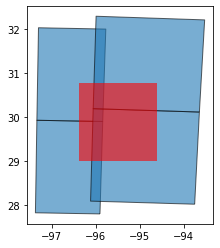

In [12]:
ax = meta.plot(alpha=.6, edgecolor='k')
gpd.GeoSeries([box(*houston_extent.bounds)]).plot(ax=ax, alpha=.6, color='r')

In [9]:
extent = gpd.GeoSeries(box(*houston.total_bounds), crs=houston.crs).to_crs('epsg:32614').iloc[0]

In [10]:
arrays = []
for path in meta.dst_path:
    r = rioxarray.open_rasterio(path)
    sub = r.rio.clip([mapping(extent)])
    arrays.append(sub)

In [13]:
merged = merge_arrays(arrays)

In [24]:
proj = merged.rio.reproject(houston.crs)

In [26]:
proj.rio.to_raster("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_houston_clipped_proj.tif")

Now we compute the actual NDVI in a loop for each chunk.

In [2]:
chunks = glob.glob(folder + "chunked/chunk_*.pq")

In [ ]:
for chunk in chunks:
    houston = gpd.read_parquet(chunk, columns=["tID", "tessellation"])
    r = rioxarray.open_rasterio("../../urbangrammar_samba/sp_sig_concept/ghs_composite_s2/S2_houston_clipped_proj.tif")
    clipped = r.rio.clip_box(*houston.total_bounds)
    masked = clipped.where(clipped != 0)
    ndvi = (masked.sel(band=4) - masked.sel(band=1)) / (masked.sel(band=4) + masked.sel(band=1))
    affine = ndvi.rio.transform()
    stats = rasterstats.zonal_stats(
        houston.geometry, 
        raster=ndvi.values,
        affine=affine,
        stats=['mean'],
        all_touched=True,
        nodata = np.nan,
    )
    houston['ndvi'] = [x["mean"] for x in stats]
    houston[["tID", "ndvi"]].to_parquet(folder + f"ndvi/ndvi{chunk[62:-3]}.pq")
    print(f"Chunk {chunk[62:-3]} processed.")

### 2.6 Historical sites

We use historical sites from [NPS](https://irma.nps.gov/DataStore/Reference/Profile/2210280).

In [2]:
download("https://irma.nps.gov/DataStore/DownloadFile/647226", folder + "historical/", kind="zip")

Creating data folder...

file_sizes: 100%|███████████████████████████| 47.0M/47.0M [01:35<00:00, 491kB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/historical/


'../../urbangrammar_samba/sp_sig_concept/houston/historical/'

Let's check which layers we got.

In [4]:
fiona.listlayers(folder + "historical/NRIS_CR_Standards_Public.gdb")

['crbldg_py',
 'crbldg_pt',
 'crsite_pt',
 'crsite_py',
 'crdist_pt',
 'crdist_py',
 'crobj_pt',
 'crobj_py',
 'crstru_pt',
 'crstru_py',
 'NR_Main']

Since we have data fro the whole US, lets open it with a mask of our case study area.

In [2]:
enclosures = gpd.read_parquet(folder + "enclosures.pq")

In [5]:
historical = gpd.read_file(folder + "historical/NRIS_CR_Standards_Public.gdb", layer="crbldg_pt", mask=enclosures)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [6]:
historical = historical.to_crs(enclosures.crs)

We loop over chunks, create pandana network and measure the number of historical buildings in 15 minutes walking distance.

In [ ]:
for c in real_chunks:    
    nodes = gpd.read_parquet(folder + f'nodes/nodes_{c}.pq')
    edges = gpd.read_parquet(folder + f'edges/edges_{c}.pq')
    nodes = nodes.set_index('nodeID')
    network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])
    network.precompute(1200)

    historical_c = gpd.clip(historical, box(*nodes.total_bounds))
    if len(historical_c) > 0:
        network.set_pois(category = 'historical',
                         maxdist = 1200,
                         maxitems=500,
                         x_col = historical_c.geometry.x, 
                         y_col = historical_c.geometry.y)

        res = network.nearest_pois(distance = 1200,
                                   category = 'historical',
                                   num_pois = len(historical_c),
                                   include_poi_ids = False)

        res = res.replace(1200, pd.NA)
        nodes['historical_counts'] = res.count(axis=1)
    else:
        nodes['historical_counts'] = pd.NA
    
    cells = gpd.read_parquet(folder + f'chunked/chunk_{c}.pq')
    cells = cells.merge(nodes, on='nodeID', how='left')
    cells[['tID', 'historical_counts']].to_parquet(folder + f"historical/hist_{c}.pq")
    print(f"chunk {c} processed")

## 3. Cluster analysis

Cluster analysis uses the data on form, function, and their combination in a K-Means clustering to identify homogenous patterns of built form.

### 3.1. Form

Clustering based on form uses contextualised characters as an input. We read all chunks at once with dask and get a single pandas dataframe for clustering.

In [2]:
form = dd.read_parquet(folder + "convolutions/*")

In [3]:
form = form.compute()

In [4]:
form = form.sort_index()
form

sdbAre_q1   sdbAre_q2   sdbAre_q3  sdbPer_q1  sdbPer_q2  sdbPer_q3  \
tID                                                                            
0        187.916473  233.429902  302.735875  57.299845  64.437949  77.367233   
1        192.239141  241.143406  328.616606  57.465556  66.312420  78.970217   
2        184.260244  232.471609  295.886632  55.439699  64.177817  76.887386   
3        190.955691  233.430144  308.303930  57.376604  64.466014  77.441126   
4        184.654271  240.947075  313.596440  56.558923  65.617217  78.419502   
...             ...         ...         ...        ...        ...        ...   
2043576  104.604450  148.479369  220.332551  43.876769  52.564118  63.430919   
2043577  104.766702  150.537484  225.839768  44.049025  52.992988  63.802713   
2043578  111.585808  173.245627  252.198691  45.563533  55.721062  69.830844   
2043579  108.561486  161.902723  243.812610  43.770154  53.997083  67.450053   
2043580  109.956453  162.805028  246.410669  43.987887  54.207183  67.503266   

         sdbCoA_q1  sdbCoA_q2  sdbCoA_q3  ssbCCo_q1  ...      mdsAre_q3  \
tID                                                  ...                  
0              0.0        0.0        0.0   0.499655  ...  165047.828475   
1              0.0        0.0        0.0   0.475410  ...  165047.828475   
2              0.0        0.0        0.0   0.505946  ...  149756.188790   
3              0.0        0.0        0.0   0.495986  ...  160402.567221   
4              0.0        0.0        0.0   0.483439  ...  165047.828475   
...            ...        ...        ...        ...  ...            ...   
2043576        0.0        0.0        0.0   0.460729  ...  286106.049794   
2043577        0.0        0.0        0.0   0.446880  ...  333598.398344   
2043578        0.0        0.0        0.0   0.463528  ...  758057.055427   
2043579        0.0        0.0        0.0   0.472102  ...  239969.668977   
2043580        0.0        0.0        0.0   0.471756  ...  236968.269085   

         lisCel_q1   lisCel_q2   lisCel_q3      ldsAre_q1     ldsAre_q2  \
tID                                                                       
0        82.453006  130.000000  220.846630  250537.961477  4.504084e+05   
1        70.792427  109.000000  222.000000  259059.004741  4.504084e+05   
2        70.629904  113.000000  211.302621  245342.423310  4.280116e+05   
3        75.172919  123.000000  194.651303  246553.588775  4.473047e+05   
4        64.975599  112.000000  222.000000  245685.146259  4.280116e+05   
...            ...         ...         ...            ...           ...   
2043576  74.349338   93.786649  108.629818  578956.490141  7.877146e+05   
2043577  73.000000   92.000000  107.000000  601459.150039  8.241394e+05   
2043578  27.000000   45.000000   60.000000  689455.267017  1.359565e+06   
2043579  84.490434  100.000000  109.151180  555422.756085  7.586352e+05   
2043580  84.369955  100.000000  109.131499  557193.131242  7.600217e+05   

            ldsAre_q3     sddAre_q1     sddAre_q2     sddAre_q3  
tID                                                              
0        7.232823e+05           NaN           NaN           NaN  
1        7.134663e+05           NaN           NaN           NaN  
2        7.111680e+05           NaN           NaN           NaN  
3        7.026945e+05           NaN           NaN           NaN  
4        7.193909e+05           NaN           NaN           NaN  
...               ...           ...           ...           ...  
2043576  1.555593e+06   8727.361500  12863.389248  21167.791522  
2043577  1.843515e+06   8681.330198  13024.296262  23661.382551  
2043578  2.467970e+06  15101.595037  36803.778676  90635.405082  
2043579  1.199090e+06   6741.686812  10707.667431  16127.169779  
2043580  1.214954e+06   6605.284800  10707.667431  16127.169779  

[2043581 rows x 177 columns]

In [5]:
tess = gpd.read_parquet(folder + "tess.pq", columns=["tID", "buildings", "tessellation"])

In [6]:
form = form.drop(columns=['sddAre_q1','sddAre_q2', 'sddAre_q3'])  # bug in the code above, should not matter much

In [7]:
form = form.replace(np.inf, np.nan)

Raw data needs to be standardised. We use standard scaler.

In [8]:
scaler = preprocessing.StandardScaler()
data = scaler.fit_transform(form)

Due to tiny minor topology issue, we have a few missing values in the whole datasets so we replace them with 0. In a dataset of 2 million rows, it does not matter much.

In [9]:
data[np.isnan(data)] = 0

We use clustergram to determine the optimal number of clusters, using 10 initializations within range from 1 to 30 clusters.

In [41]:
cg_form = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_form.fit(data)

PCA computed in 8.410962343215942 seconds.
K=1 fitted in 10.196556329727173 seconds.
K=2 fitted in 30.631512880325317 seconds.
K=3 fitted in 36.73029851913452 seconds.
K=4 fitted in 46.16954755783081 seconds.
K=5 fitted in 74.35213446617126 seconds.
K=6 fitted in 90.30173182487488 seconds.
K=7 fitted in 79.47916674613953 seconds.
K=8 fitted in 96.70337891578674 seconds.
K=9 fitted in 123.44440960884094 seconds.
K=11 fitted in 134.06192064285278 seconds.
K=12 fitted in 122.80384421348572 seconds.
K=13 fitted in 141.75970315933228 seconds.
K=14 fitted in 164.42598748207092 seconds.
K=15 fitted in 183.27930212020874 seconds.
K=16 fitted in 180.3209307193756 seconds.
K=17 fitted in 202.2183780670166 seconds.
K=18 fitted in 268.55466318130493 seconds.
K=19 fitted in 254.6953580379486 seconds.
K=20 fitted in 347.1559338569641 seconds.
K=21 fitted in 365.82175493240356 seconds.
K=22 fitted in 388.84376215934753 seconds.
K=23 fitted in 390.1371464729309 seconds.
K=24 fitted in 377.011963129043

Now we can plot resulting clustergam. Due to outliers, we truncate y axis to see the behaviour of clusters.

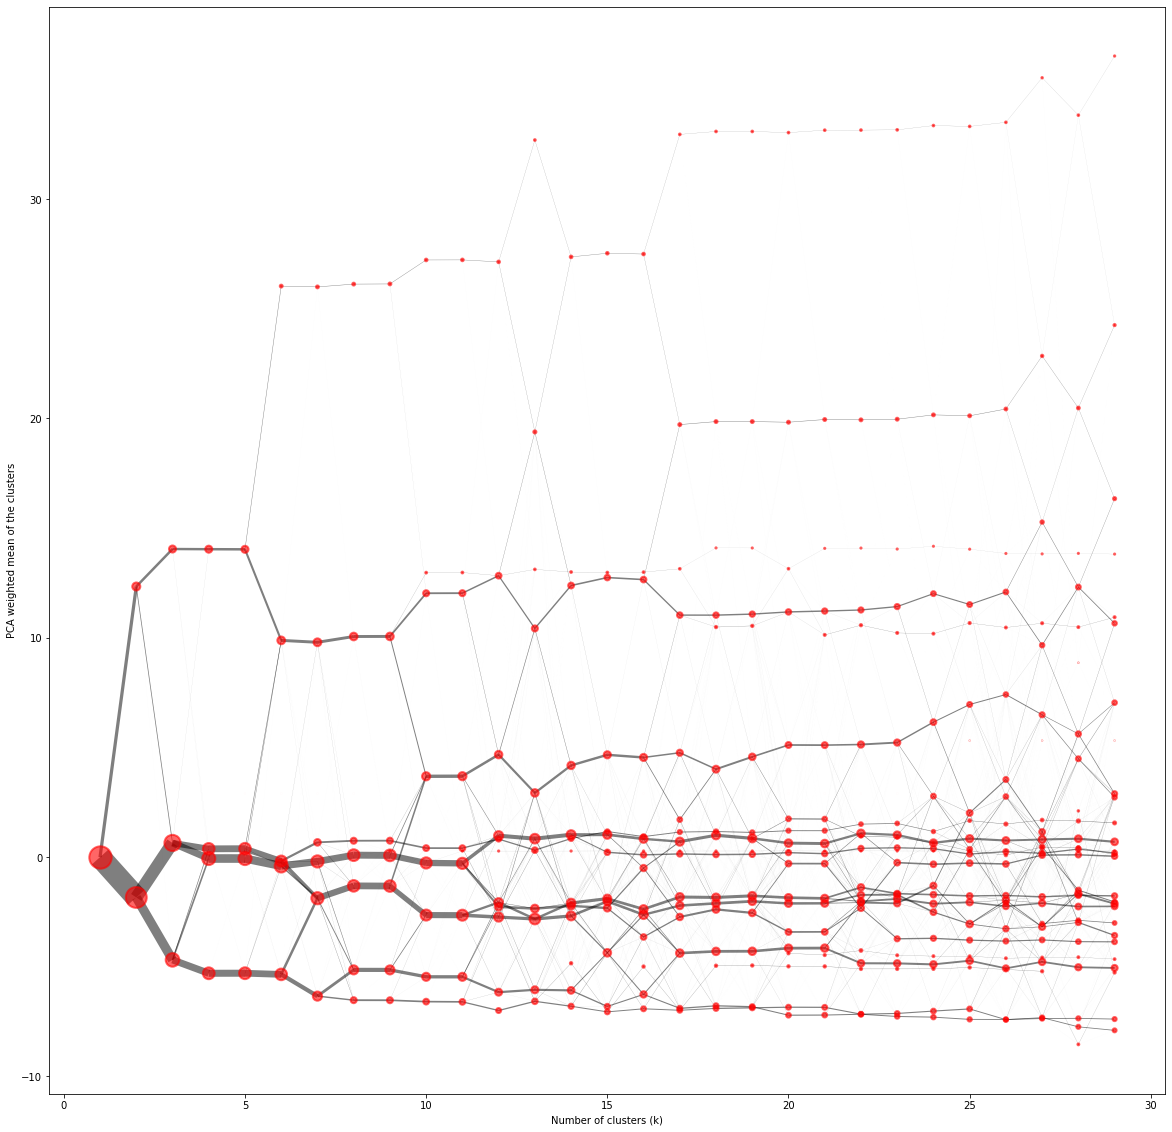

In [42]:
ax = cg_form.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
# ax.set_ylim(-10, 40)

Based on the clustergram, we can assume that 12 clusters is the optimal number. 12 is the first point after all major branching happens and the situation stabilizes.

Before proceeding, we also save clustergam object to a file.

In [43]:
with open(folder + 'clustergram_form.pickle','wb') as f:
    pickle.dump(cg_form, f)

Let's see how 12 clusters based on form look like spatially.

In [44]:
%time km_form = KMeans(n_clusters=12, n_init=100).fit(data)

CPU times: user 2h 22min 16s, sys: 18min 32s, total: 2h 40min 49s
Wall time: 23min


In [45]:
tess['clusters_form'] = km_form.labels_

We can plot the labels based on tessellation or based on buildings, each providing different insights.

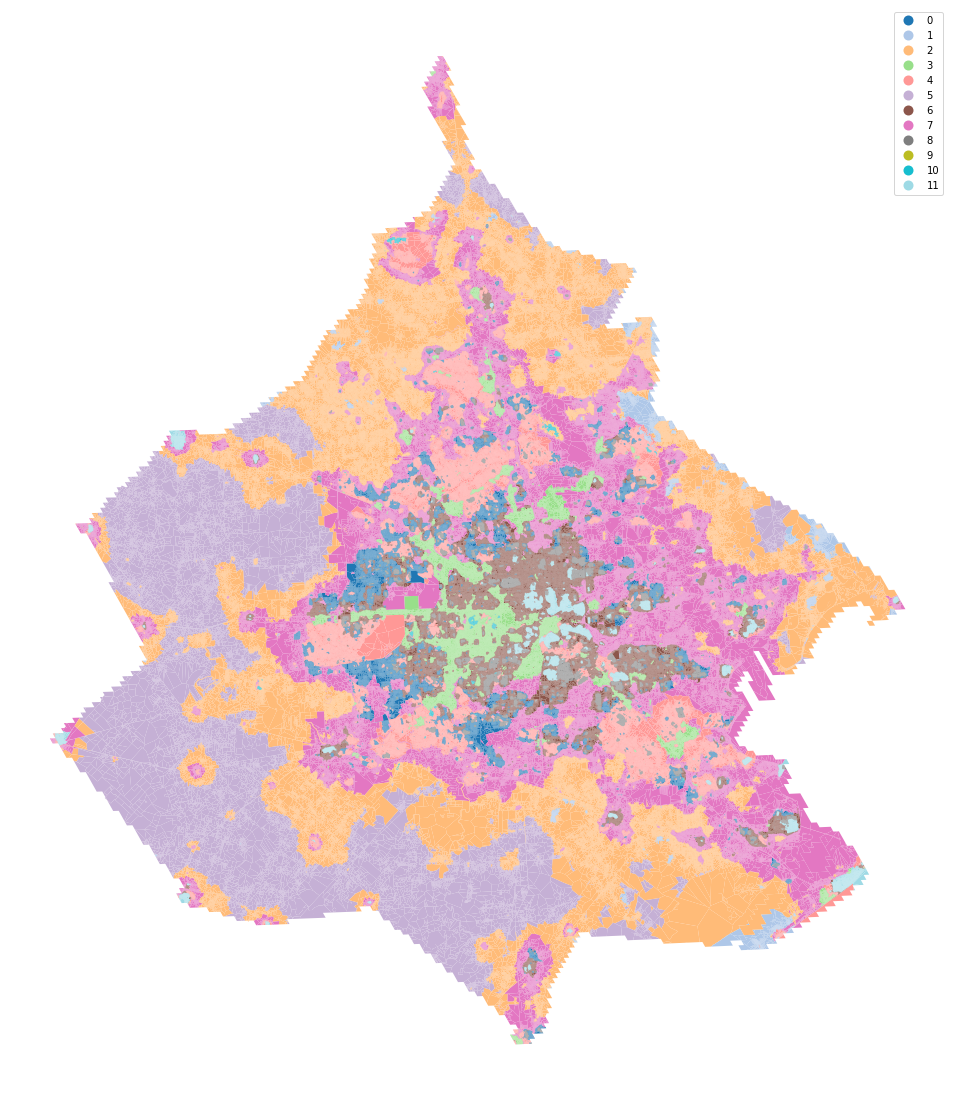

In [46]:
ax = tess.plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [47]:
ax = tess.set_geometry('buildings').plot('clusters_form', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.2. Function

Clustering based on function uses only data on function, which we need to prepare. First we have to merge all together.

In [10]:
population = pd.read_parquet(folder + "population/population.pq")

In [11]:
land_cover = pd.read_parquet(folder + "land_cover/land_cover.pq")

In [12]:
workplace = pd.read_parquet(folder + "workplace.pq")
night_lights = pd.read_parquet(folder + "night_lights/night_lights.pq")

In [13]:
historical = dd.read_parquet(folder + "historical/*.pq").compute()
ndvi = dd.read_parquet(folder + "ndvi/*.pq").compute()

In [14]:
historical = historical.set_index('tID').sort_index().fillna(0)

In [15]:
ndvi = ndvi.set_index('tID').sort_index()

We have some categorical values, so we have to encode them as boolean dummies.

In [16]:
lc = pd.get_dummies(land_cover.land_cover)

In [17]:
function_data = workplace.merge(night_lights, on='tID').merge(historical, on='tID').merge(ndvi, on='tID').merge(population, on='tID').set_index('tID')

Continuous values need to be standardized.

In [18]:
scaler = preprocessing.StandardScaler()
f_data = scaler.fit_transform(function_data)

We can all merge back together.

In [19]:
f_data = np.hstack([f_data, lc.values])

In [20]:
f_data[np.isnan(f_data)] = 0

We are using clustergram again.

In [ ]:
cg_function = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_function.fit(f_data)

PCA computed in 5.356017112731934 seconds.
K=1 fitted in 3.6033363342285156 seconds.
K=2 fitted in 7.137749433517456 seconds.
K=3 fitted in 9.59592866897583 seconds.
K=4 fitted in 14.273530960083008 seconds.
K=5 fitted in 16.84951162338257 seconds.
K=6 fitted in 24.39214062690735 seconds.
K=7 fitted in 29.53160309791565 seconds.
K=8 fitted in 31.604748249053955 seconds.
K=9 fitted in 29.511993885040283 seconds.
K=10 fitted in 34.95822596549988 seconds.
K=11 fitted in 38.87216782569885 seconds.
K=12 fitted in 40.553459882736206 seconds.
K=13 fitted in 50.92583870887756 seconds.
K=14 fitted in 58.26849699020386 seconds.
K=15 fitted in 54.05532479286194 seconds.
K=16 fitted in 63.82630729675293 seconds.
K=17 fitted in 63.73769998550415 seconds.
K=18 fitted in 66.51052403450012 seconds.
K=19 fitted in 65.87838172912598 seconds.
K=20 fitted in 73.46614909172058 seconds.
K=21 fitted in 71.83540964126587 seconds.
K=22 fitted in 84.23949003219604 seconds.
K=23 fitted in 73.23946404457092 secon

In [48]:
ax = cg_function.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-3, 3)

(-3.0, 3.0)

Clustergram should be saved to a file.

In [ ]:
with open(folder + 'clustergram_function.pickle','wb') as f:
    pickle.dump(cg_function, f)

We can interpret the diagram as 9 clusters being the optimum.

The figures below show 9 clusters.

In [53]:
km_function = KMeans(n_clusters=9, n_init=100).fit(f_data)

In [54]:
tess['clusters_function'] = km_function.labels_

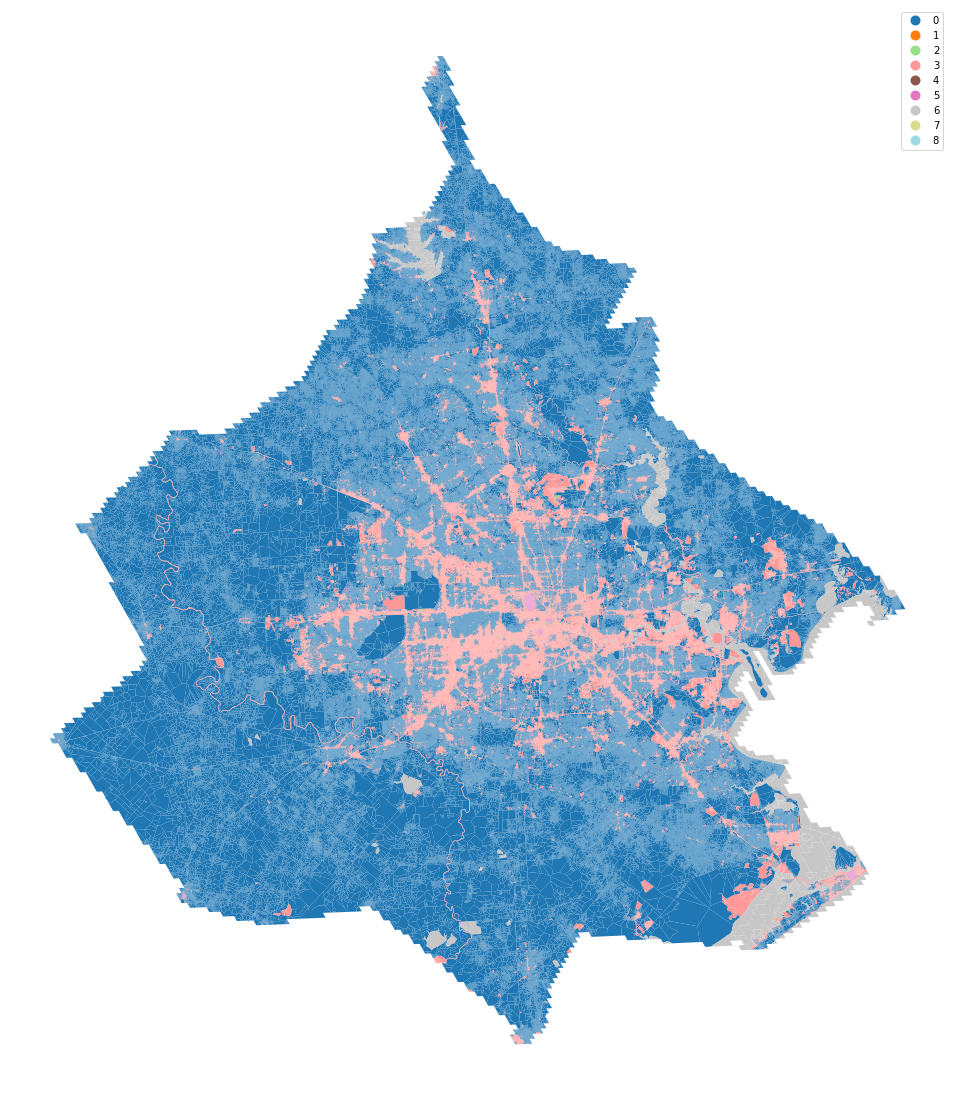

In [55]:
ax = tess.plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [56]:
ax = tess.set_geometry('buildings').plot('clusters_function', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

### 3.3. Spatial Signatures

Final clustering combines both form and function into a singular classification.

First we stack both preprocessed arrays together and then run clustergram.

In [21]:
ss_data = np.hstack([data, f_data])

In [ ]:
cg_ss = Clustergram(range(1, 30), backend='sklearn', n_init=10)
cg_ss.fit(ss_data)

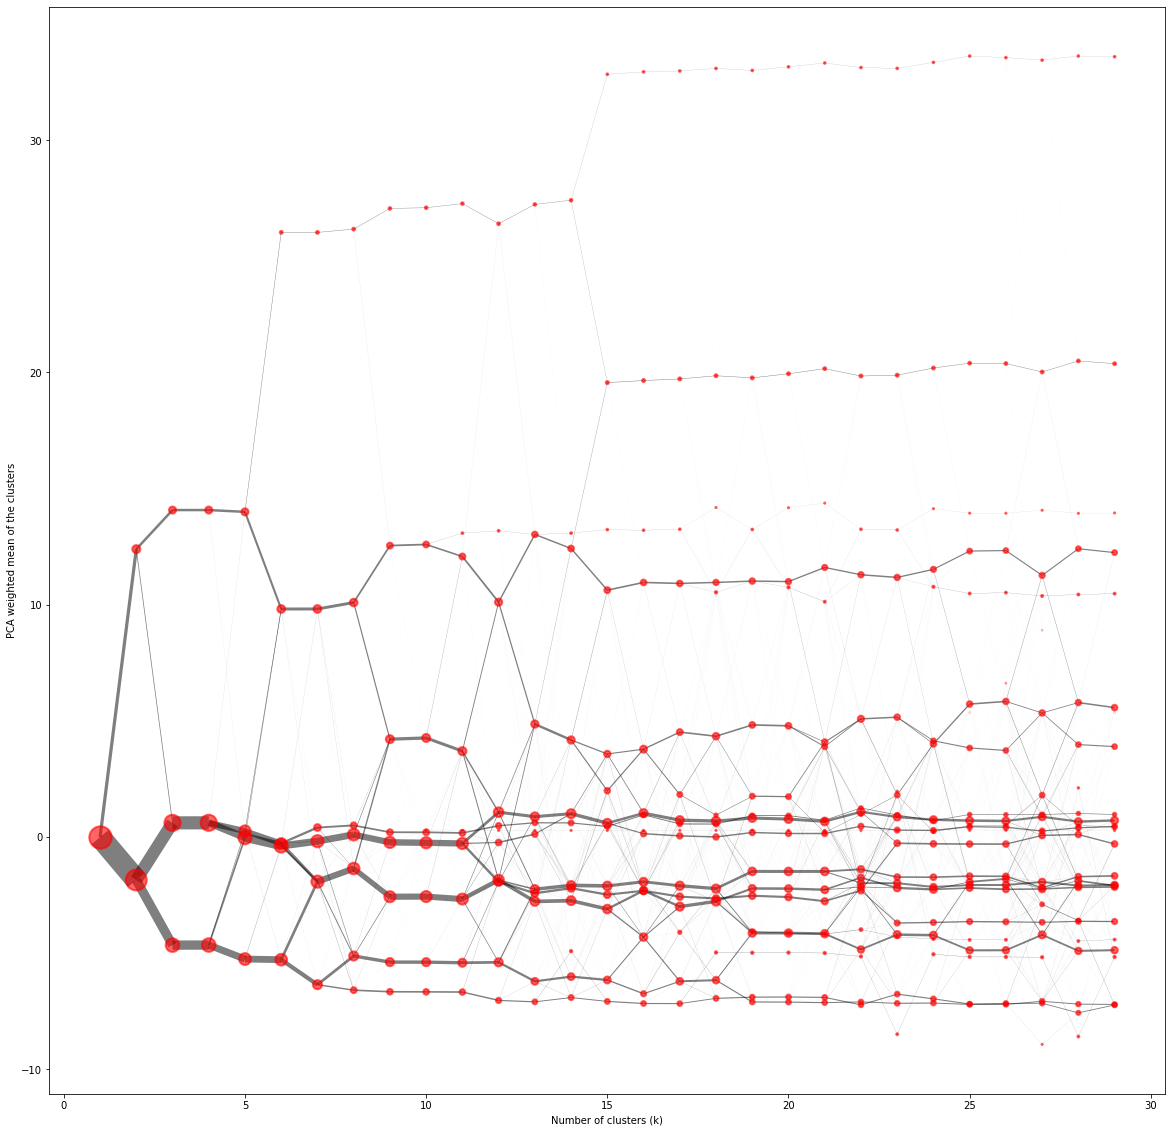

In [46]:
ax = cg_ss.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
# ax.set_ylim(-10, 25)

In [ ]:
with open(folder + 'clustergram_ss.pickle','wb') as f:
    pickle.dump(cg_ss, f)

The optimal number in this case seems to be 9 clusters. We run final clustering with 1000 initiazations and fixed random state for reproducibility.

In [ ]:
km = KMeans(n_clusters=9, n_init=1000, random_state=12345).fit(ss_data)

In [ ]:
tess['clusters'] = km.labels_

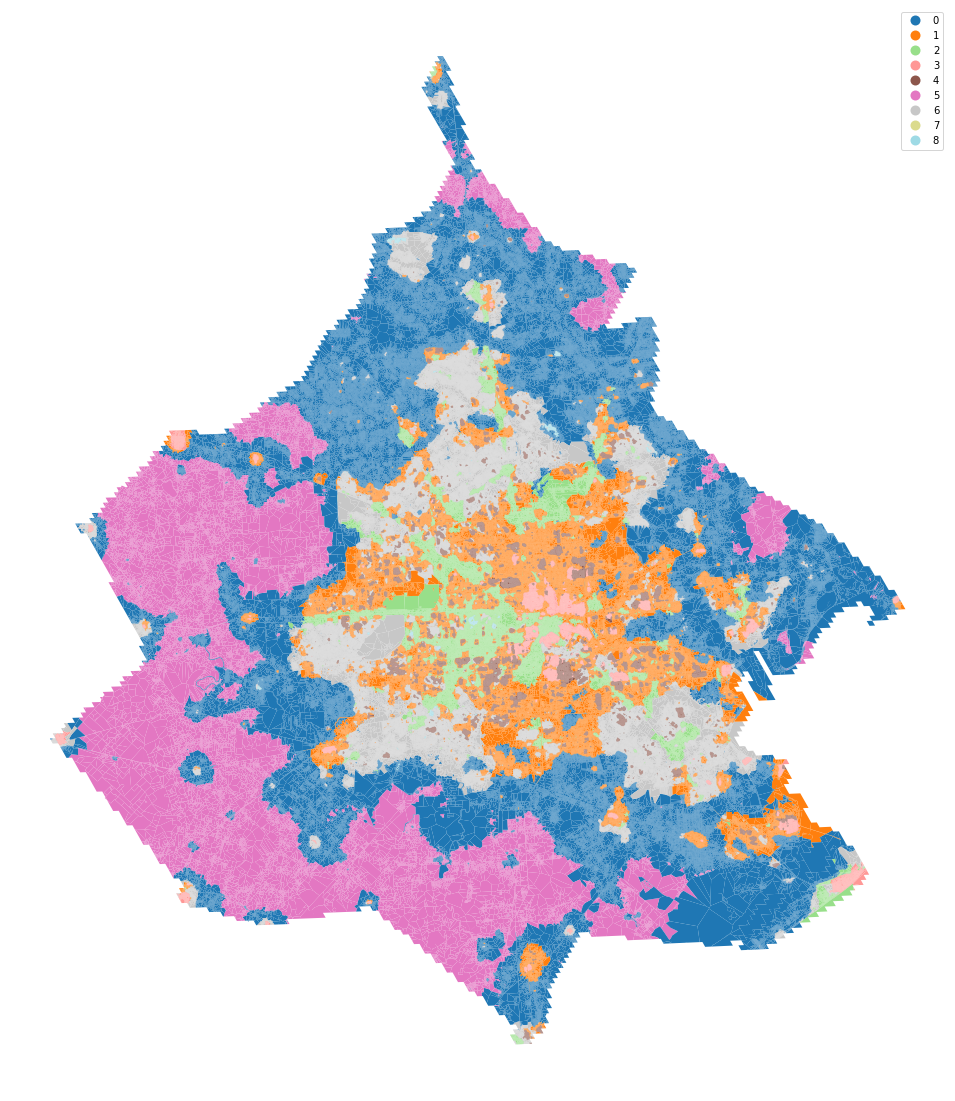

In [30]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

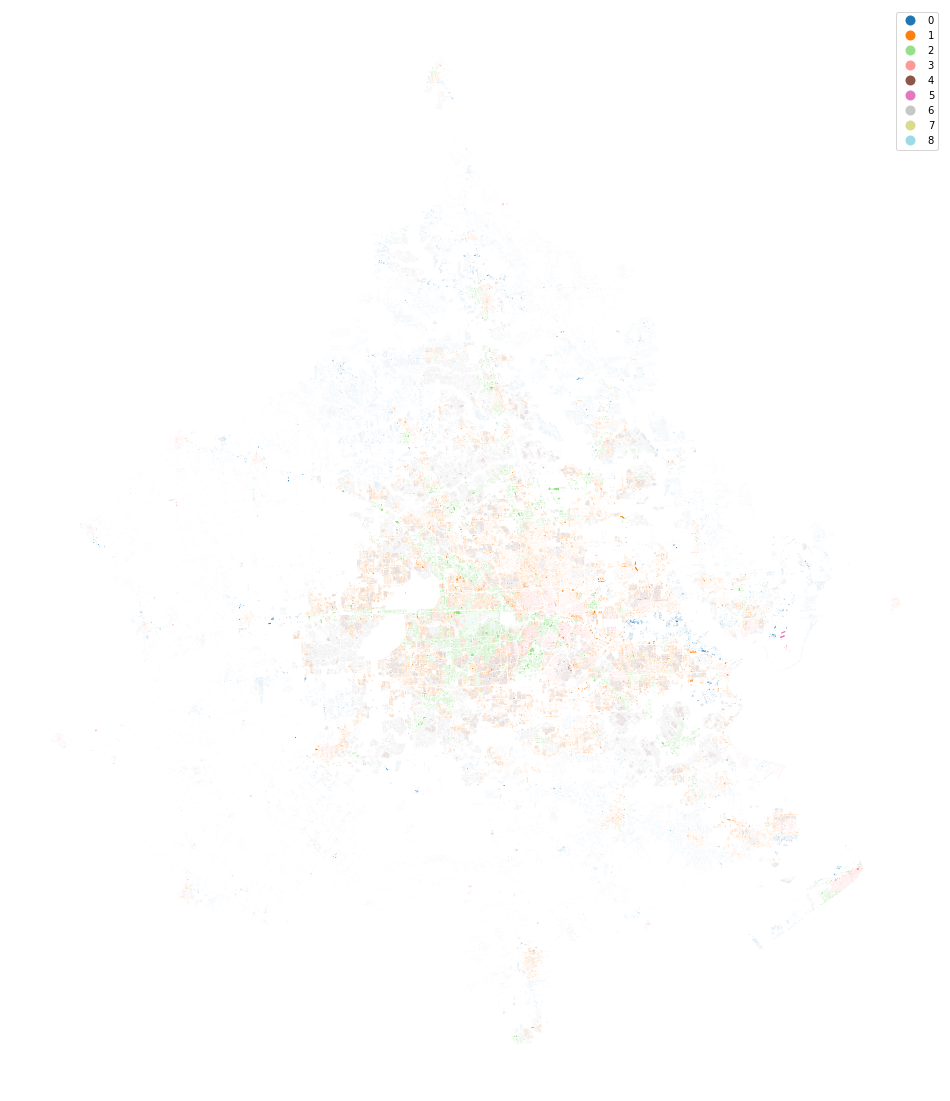

In [31]:
ax = tess.set_geometry('buildings').plot(tess['clusters'].replace({10: 18}), categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [ ]:
tess[['tID', 'clusters',]].to_csv(folder + "FINAL_cluster_labels.csv")

In [57]:
tess[['tID', 'clusters', 'clusters_form', 'clusters_function']].to_parquet(folder + "cluster_labels.pq")

#### Generate signatures

As a final step, we can generate a geometry representing spatial singatures as a combination of contiguous tessellation cells belonging to a single cluster. Since we have to dissolve a large number of polygons, we use dask_geopandas to parallelize the procedure.

First we create a local cluster.

In [2]:
client = Client(LocalCluster(n_workers=16))
client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35751 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:37721' processes=16 threads=16, memory=134.91 GB>

We read only 'tessellation' columns and cluster labels. The resulting geometry will not be enclosed tessellation anymore so we can already rename it to generic "geometry".

In [3]:
tess = gpd.read_parquet(folder + "tess.pq", columns=['tessellation']).rename_geometry("geometry")
clusters = pd.read_csv(folder + "FINAL_cluster_labels.csv", index_col=0)

In [4]:
tess['cluster'] = clusters.clusters.values

`dask_dissolve` mimics the behaviour of `geopandas.dissolve`, just based on parallel implementation using `dask-geopandas`.

In [8]:
%%time
ddf = dask_geopandas.from_geopandas(tess.sort_values('cluster'), npartitions=64)
final = dask_dissolve(ddf, by='cluster').compute()

CPU times: user 1min 34s, sys: 10 s, total: 1min 44s
Wall time: 13min 58s


In [ ]:
final.plot('cluster', categorical=True, figsize=(20, 20), cmap='tab20')

Finally, we explode the geometries to get multiple singatures of the same kind instead of a single multipolygon. (The intial `reset_index` is here to avoid bug in geopandas.)

In [ ]:
final.reset_index(drop=True).explode().reset_index(drop=True).to_parquet(folder + "signatures.pq")

Before we end, we close dask client.

In [16]:
client.close()

# 4. Figures

Finally, we create final figures.